In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

## Data import and plot

In [2]:
# import data from excel

glmS1 = pd.read_excel('2023_glmS_PIFE&cleavage_1.xlsx')
glmS1 = glmS1.to_numpy()


In [3]:
# read PIFE data as a list

PIFE_list = []
Activation_list = []

for r in range(len(glmS1)):
    PIFE_list.append(glmS1[r,1])
    if not np.isnan(glmS1[r,2]):
        Activation_list.append(glmS1[r,2])


45.49385474860336 3.776806046365491


Text(0, 0.5, 'Probability density')

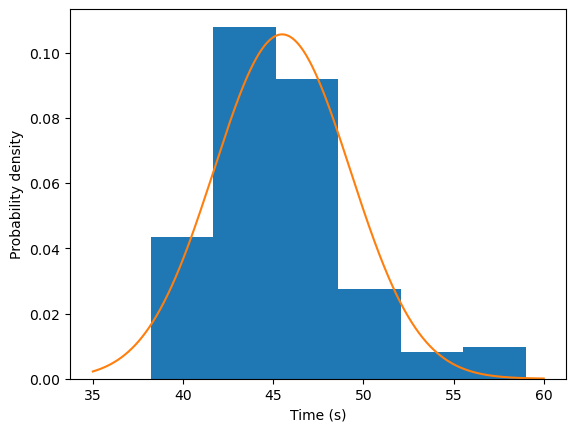

In [4]:
# plot PDF of PIFE data and fit to norm distribution

(mu, sigma) = norm.fit( PIFE_list )
x = np.arange(35, 60, 0.001)
print(mu, sigma)

plt.figure()
plt.hist(PIFE_list, bins=6, density=True)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.xlabel("Time (s)", fontsize=10)
plt.ylabel("Probability density", fontsize=10)

In [5]:
# calculate CDF

PIFE_list.sort()
p_PIFE = np.arange(len(PIFE_list)) / (len(PIFE_list) - 1)  #CDF for each data t

PIFE_T_nonrep = [0]  # generate a list to store data t without duplicate
PIFE_p_nonrep = [0]  # cumulative probability for each nonrepeat data t

# remove duplicate data in the CDF
for r in range(len(PIFE_list)):
    PIFE_time = PIFE_list[r]
    if PIFE_time not in PIFE_T_nonrep:   
        PIFE_T_nonrep.append(PIFE_time)
        PIFE_p_nonrep.append(p_PIFE[r])
    else:
        PIFE_p_nonrep[-1] = p_PIFE[r]


Text(0, 0.5, 'Probability density')

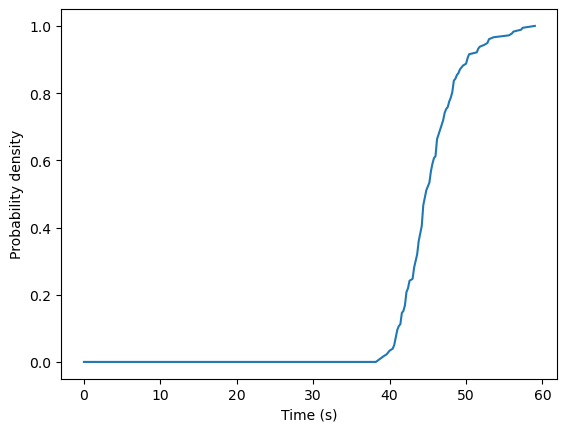

In [6]:
# plot CDF
plt.figure()
plt.plot(PIFE_T_nonrep, PIFE_p_nonrep)
plt.xlabel("Time (s)", fontsize=10)
plt.ylabel("Probability density", fontsize=10)

## Implememt ODE of the transcription model

In [7]:
DIM = 500  # gradient matrix dimention

# define initial N state at T=0
N0 = np.zeros([DIM,1])
N0[0,0] = 1.0

In [8]:
# define gradient parameters

def ParaNSetup(rate, pause, fraction):
    # rate: k_fast
    # pause: k_slow
    # fraction: fraction of molecule without pause
    # define fast K (no pause)
    
    K1 = np.zeros([DIM, DIM]) # DIM x DIM
    for i in range(DIM-1):
        K1[i,i] = - rate
        K1[i+1,i] = rate
        
    # define slow K (with pause)
    K2 = np.zeros([DIM, DIM]) # DIM x DIM
    for i in range(DIM-1):
        K2[i,i] = - rate
        K2[i+1,i] = rate
    K2[300,300] = - pause #RNAP pausing with a slow rate here
    K2[300+1,300] = pause
        
    return K1, K2, fraction


In [9]:
# integrate ODE

def ODE_int(K, T_interval, N_init, stepsize):
    # K: gradient matrix
    # T_interval: integral interval
    # N_init: initial N state at T
    # stepsize: dt
    steps = int(T_interval / stepsize)
    N = N_init.copy()
    for t in range(steps):
        N += stepsize * ( np.matmul(K, N) )
    return N.copy()  # N state after integral from T to  T+ T_interval

In [10]:
# calculate N state at a list of time T for a given set of parameters

def mix_double_ODE(params, Ts, N_init, stepsize=0.001):
    # rate, pause, fraction = params
    # Ts is a list of time starting from 0
    # N_init: initial N state at Ts[i]

    K1, K2, fraction = ParaNSetup(*params)
    
    N_fast, N_slow = N_init.copy() * fraction, N_init.copy() * (1-fraction)   # define initial states of fast population and slow population
  
    Ns = [N_fast + N_slow] # create a list to store N state for each T

    for i in range(len(Ts)-1):
        T_interval = Ts[i+1] - Ts[i]
        N_fast = ODE_int(K1, T_interval, N_fast, stepsize)
        N_slow = ODE_int(K2, T_interval, N_slow, stepsize)        
        Ns.append( N_fast + N_slow ) # N state after integral to Ts[i+1]
    
    Ns = np.array(Ns)
    return Ns

# take the last dimension: the population of molecules that has transcribed to the end

def mix_double_ODE_N500(params, Ts, N_init, stepsize=0.001):
    Ns = mix_double_ODE(params, Ts, N_init)
    return Ns[:,-1].reshape(-1)

## Fit the model to experimental data using least squares and grid search 

In [11]:
# mean squared error

def MSE(Ns_target, Ns_pred):
    # mean squared error
    return np.sqrt( ((Ns_target - Ns_pred)**2).mean() )

In [12]:
# test ODE for a random set of params

params = (11.5, 0.3, 0.7)
N500_pred = mix_double_ODE_N500(params, PIFE_T_nonrep, N0, stepsize=0.001) # the simulated CDF of the random paraters

mse = MSE(PIFE_p_nonrep, N500_pred) # deviation of data to model
print(mse)

0.08720439561767637


In [13]:
# calculate mse for a grid of candidate parameters from experimental data points to find the optimal parameters

def grid_research( params_grid ):
    
    error_grid = []
    
    for params in params_grid:
        N500_pred = mix_double_ODE_N500(params, PIFE_T_nonrep, N0, stepsize=0.01)
        mse = MSE(np.array(PIFE_p_nonrep), N500_pred)     # input experimental CDF and calculate mse
        error_grid.append(mse)
        #print("current params", params, "current error", mse)
    
    # find the optimal parameters with the least mse
    opt_error = min(error_grid)  
    opt_index = error_grid.index(opt_error)
    opt_param = params_grid[opt_index]
    return opt_param, opt_error

In [14]:
# create a grid of candidate parameters

rate_candidates = np.arange(11.0,12.3,0.3)
pause_candidates = np.arange(0,1,0.3)
frac_candidates = np.arange(0,1,0.3)

params_grid = np.meshgrid(rate_candidates, pause_candidates, frac_candidates)
params_grid = np.array(params_grid).reshape(3,-1).T 

In [15]:
opt_param, opt_error = grid_research(params_grid)

print(opt_param)

[11.6  0.3  0.3]


In [23]:
# second round of a grid search around the optimal candidate

rate_candidates2 = np.arange(11.4,11.8,0.1)
pause_candidates2 = np.arange(0.2,0.5,0.1)
frac_candidates2 = np.arange(0.2,0.5,0.1)

params_grid2 = np.meshgrid(rate_candidates2, pause_candidates2, frac_candidates2)
params_grid2 = np.array(params_grid2).reshape(3,-1).T 

In [24]:
opt_param2, opt_error2 = grid_research(params_grid2)

print(opt_param2)

[11.7  0.3  0.2]


In [25]:
## Plot model

In [26]:
# Use fitted parameters to compute the model
Ts = np.arange (0,60,0.1)

N500s = mix_double_ODE_N500(opt_param2, Ts, N0, stepsize=0.01)


Text(0, 0.5, 'Cumulative probability')

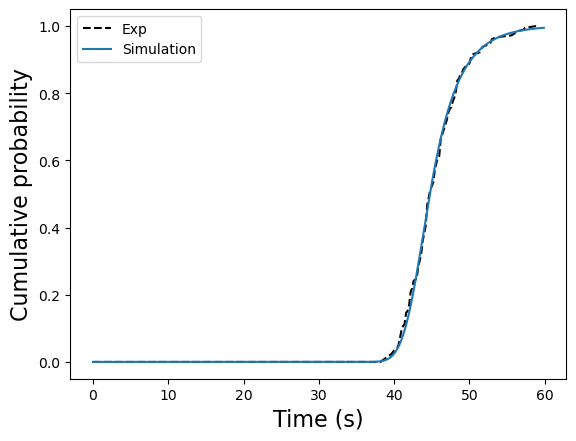

In [27]:
# plot experimental data and the simulation kinetics model with fitted parameters

fig, ax = plt.subplots()
plt.plot(PIFE_T_nonrep, PIFE_p_nonrep,'k',label='Exp',linestyle = 'dashed')
plt.plot(Ts, N500s,label='Simulation')
plt.legend(loc="upper left")
ax.set_xlabel("Time (s)", fontsize=16)
ax.set_ylabel("Cumulative probability", fontsize=16)
